In [40]:
import pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch

In [41]:
# load the dataset
dataframe = pd.read_csv('archive/spx.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[ 209.59],
       [ 210.88],
       [ 210.65],
       ...,
       [2699.63],
       [2716.31],
       [2718.37]], dtype=float32)

In [42]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5734 2458


In [43]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [44]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [45]:
trainX.shape

(5732, 1)

In [46]:
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [47]:
#automatically fit the optimal ARIMA model for given time series
arima_model_fitted = pmdarima.auto_arima(train,information_criterion='bic')
# one-step out-of sample forecast
# forecast = arima_model_fitted.predict(n_periods=1)[0]

# # load statsmodels
# import statsmodels.tsa.arima_model stm
# # fit ARIMA model
# model = stm.ARIMA(dataset, order=(3,1,2))
# model_fit = model.fit()
# # one-step out-of sample forecast
# forecast = model_fit.forecast()[0]

In [48]:
arima_model_fitted

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [49]:
forecasts = []
for i in range(len(train)-1,len(dataset)):
    forecast = arima_model_fitted.fit_predict(dataset[:i], n_periods=1)
    forecasts.append(forecast)
forecasts = np.array(forecasts)

In [50]:
RMSE= np.sqrt(np.sum((forecasts - dataset[len(train)-1:])**2)/len(forecasts))
RMSE*100

1669.9786268295145

In [53]:
print(forecasts[:5,],dataset[len(train)-1:len(train)+4])

[[1189.86979669]
 [1187.24333852]
 [1208.93526863]
 [1212.61462122]
 [1112.16058301]] [[1185.87]
 [1209.18]
 [1213.01]
 [1106.39]
 [1166.36]]


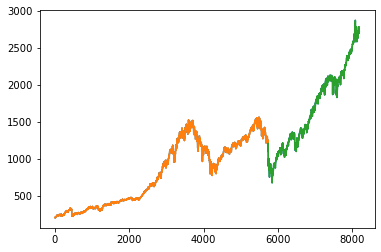

In [51]:
# # shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train)+look_back, :] = train
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train)-1:len(dataset), :] = forecasts
# # plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

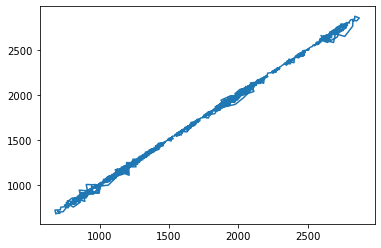

In [52]:
look_back = 1
# # shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train)+look_back, :] = train
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train)-1:len(dataset), :] = forecasts
# # plot baseline and predictions
# plt.plot(dataset[len(train)-1:len(dataset), :])
# plt.plot(trainPredictPlot)
# plt.plot(dataset[len(train)-1:len(dataset), :])
plt.plot(forecasts,dataset[len(train)-1:len(dataset), :])
plt.show()

## Combining ARIMA and GARCH

In [14]:
# fit ARIMA on returns 
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals,vol='GARCH', p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3049194.6622412466
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6539398.585471758
Iteration:      3,   Func. Count:     20,   Neg. LLF: 29081.09929952151
Iteration:      4,   Func. Count:     25,   Neg. LLF: 29813.291286285545
Iteration:      5,   Func. Count:     32,   Neg. LLF: 40995.9062130589
Iteration:      6,   Func. Count:     38,   Neg. LLF: 28876.91323881404
Iteration:      7,   Func. Count:     43,   Neg. LLF: 28881.53625850092
Iteration:      8,   Func. Count:     49,   Neg. LLF: 28865.59922804802
Iteration:      9,   Func. Count:     54,   Neg. LLF: 28864.86995076775
Iteration:     10,   Func. Count:     59,   Neg. LLF: 28864.7303799258
Iteration:     11,   Func. Count:     64,   Neg. LLF: 9122378.902068824
Iteration:     12,   Func. Count:     73,   Neg. LLF: 28968.125964413237
Iteration:     13,   Func. Count:     81,   Neg. LLF: 28941.973070195098
Iteration:     14,   Func. Count:     89,   Neg. LLF: 28864.74

D:\Users\alepi\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\Users\alepi\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [15]:
arima_residuals

array([ 2.09589996e+02,  1.29162358e+00, -1.64547149e-01, ...,
        3.54953541e+00, -2.49021395e+01,  1.43380262e+01])

In [16]:
garch

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x1fffa79cb50

In [17]:
garch_fitted

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -28864.7
Distribution:                  Normal   AIC:                           57737.5
Method:            Maximum Likelihood   BIC:                           57765.5
                                        No. Observations:                 8191
Date:                Wed, Apr 27 2022   Df Residuals:                     8190
Time:                        13:11:18   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3332  5.639e-02      5.909  3.435e-09 [  0.223,  0.44

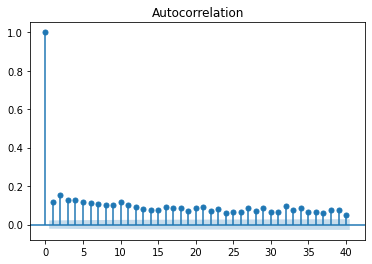

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(arima_residuals**2)
plt.show()

In [28]:
garch = arch.arch_model(arima_residuals,vol='GARCH', p=2, q=2)
garch_fitted = garch.fit(update_freq=0)
# garch_fitted

In [20]:
# fit ARIMA on returns 
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals,vol='GARCH', p=2, q=2)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      8,   Neg. LLF: 3107477.7880804962
Iteration:      2,   Func. Count:     16,   Neg. LLF: 854775.5935534141
Iteration:      3,   Func. Count:     25,   Neg. LLF: 29888.906258778068
Iteration:      4,   Func. Count:     33,   Neg. LLF: 28966.816879177546
Iteration:      5,   Func. Count:     40,   Neg. LLF: 43261.36030696145
Iteration:      6,   Func. Count:     48,   Neg. LLF: 28948.14093922356
Iteration:      7,   Func. Count:     57,   Neg. LLF: 29458.498370897807
Iteration:      8,   Func. Count:     65,   Neg. LLF: 29224.063668939147
Iteration:      9,   Func. Count:     74,   Neg. LLF: 28930.296160165657
Iteration:     10,   Func. Count:     82,   Neg. LLF: 28861.99759449055
Iteration:     11,   Func. Count:     89,   Neg. LLF: 28861.941646315245
Iteration:     12,   Func. Count:     96,   Neg. LLF: 28861.901979443777
Iteration:     13,   Func. Count:    103,   Neg. LLF: 28861.873964663242
Iteration:     14,   Func. Count:    110,   Neg. LLF: 2

D:\Users\alepi\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [31]:
forecasts = []
for i in range(len(train)-1,len(dataset)):
    foremu = arima_model_fitted.fit_predict(dataset[:i], n_periods=1)
    arima_residuals = arima_model_fitted.arima_res_.resid
    garch = arch.arch_model(arima_residuals,vol='GARCH', p=2, q=2)
    garch_fitted = garch.fit(update_freq=0, disp="off")
    predicted_et = garch_forecast.mean['h.1'].iloc[-1]
    forecast = predicted_mu + predicted_et
    forecasts.append(forecast)
forecasts = np.array(forecasts)

D:\Users\alepi\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\Users\alepi\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\Users\alepi\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
D:\Users\alepi\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warning

In [38]:
RMSE= np.sqrt(np.sum((forecasts - dataset[len(train)-1:])**2)/len(forecasts))
RMSE*100

5745801.825718816

2459

In [37]:
np.sum((dataset[len(train)-1:]-forecasts))

-6208716960.821202